In [66]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 18, 'font.family':'times new roman'})
plt.rc('legend', fontsize=12)

import numpy as np
from YPR_funcs import *

from math import ceil, floor, isnan
import random

################## CONSTANTS ##################
# gravity
g = 9.81  # m/s^2
# m to ft
ft = 3.2884  # ft/m

## First 2 Seconds: SIFT 2

In [3]:
################## DATA FRAME ##################
datafile = 'Trunc_NASA_S2.csv'
fields = ['Timestamp', 'Pres',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  'Yaw', 'Pitch', 'Roll']
df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)
################## INIT VECTORS ##################
start = 201
t_motor_burn = 300#-1#100#850 # FOR SIFT 1 ONLY
########################################################
t_IMU = df['Timestamp'].values[start:t_motor_burn]
yaw_IMU = df['Yaw'].values[start:t_motor_burn]
pitch_IMU = df['Pitch'].values[start:t_motor_burn]
roll_IMU = df['Roll'].values[start:t_motor_burn]
t_IMU = (t_IMU - t_IMU[0])

ax_vn = df['LinearAccelNed X'].values[start:t_motor_burn]
ay_vn = df['LinearAccelNed Y'].values[start:t_motor_burn]
az_vn = df['LinearAccelNed Z'].values[start:t_motor_burn]

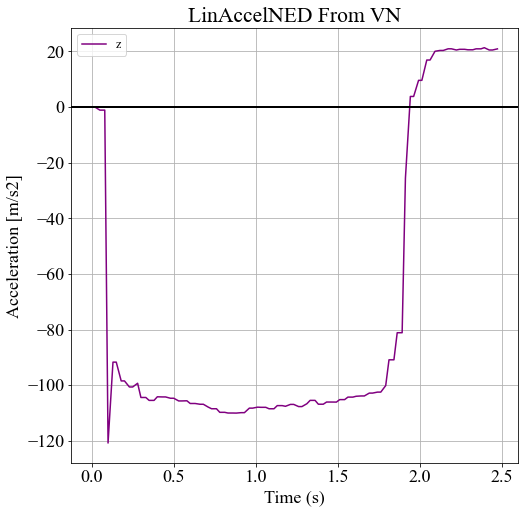

In [4]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
#l2 = ax.plot(t_IMU, ax_vn, color='red', label='x')
#l3 = ax.plot(t_IMU, ay_vn, color='green', label='y')
l4 = ax.plot(t_IMU, az_vn, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s2]")
ax.legend()
ax.grid()
plt.show()

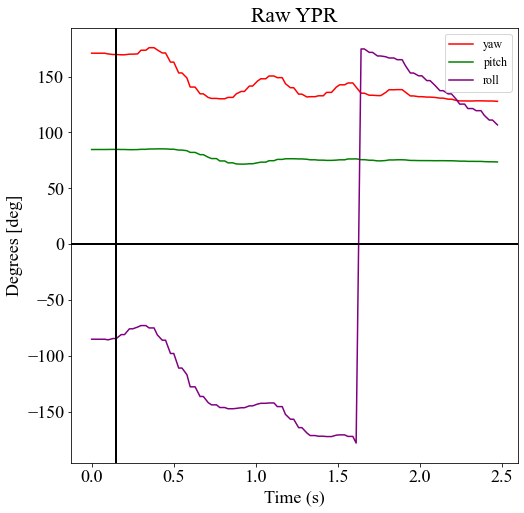

In [5]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, yaw_IMU, color='red', label='yaw')
l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
l4 = ax.plot(t_IMU, roll_IMU, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Raw YPR")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
plt.show()

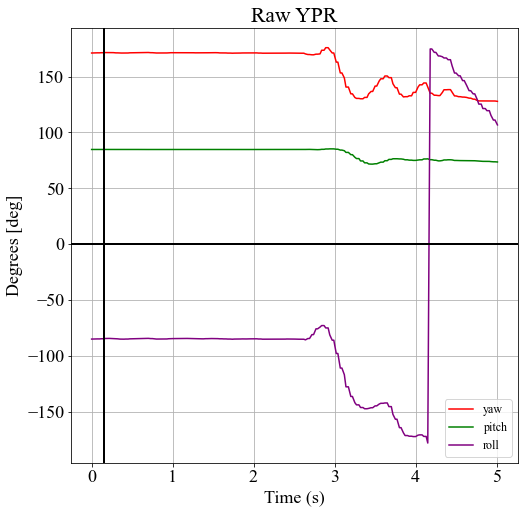

In [6]:
start = 100
t_motor_burn = 300#-1#100#850 # FOR SIFT 1 ONLY
########################################################
t_IMU = df['Timestamp'].values[start:t_motor_burn]
yaw_IMU = df['Yaw'].values[start:t_motor_burn]
pitch_IMU = df['Pitch'].values[start:t_motor_burn]
roll_IMU = df['Roll'].values[start:t_motor_burn]
t_IMU = (t_IMU - t_IMU[0])

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, yaw_IMU, color='red', label='yaw')
l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
l4 = ax.plot(t_IMU, roll_IMU, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Raw YPR")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

start = 201
t_motor_burn = 300#-1#100#850 # FOR SIFT 1 ONLY
########################################################
t_IMU = df['Timestamp'].values[start:t_motor_burn]
yaw_IMU = df['Yaw'].values[start:t_motor_burn]
pitch_IMU = df['Pitch'].values[start:t_motor_burn]
roll_IMU = df['Roll'].values[start:t_motor_burn]
t_IMU = (t_IMU - t_IMU[0])

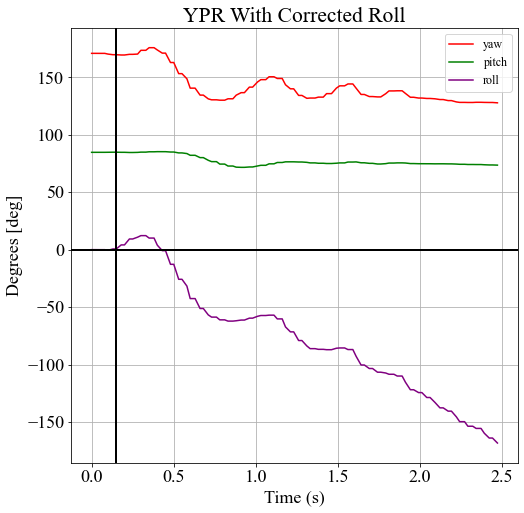

In [7]:
zero_adj_roll = roll_IMU - roll_IMU[0]
adj_roll = list(zero_adj_roll[:65])
temp_array = np.array(zero_adj_roll[65:]) - 360
adj_roll.extend(list(temp_array))

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, yaw_IMU, color='red', label='yaw')
l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("YPR With Corrected Roll")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

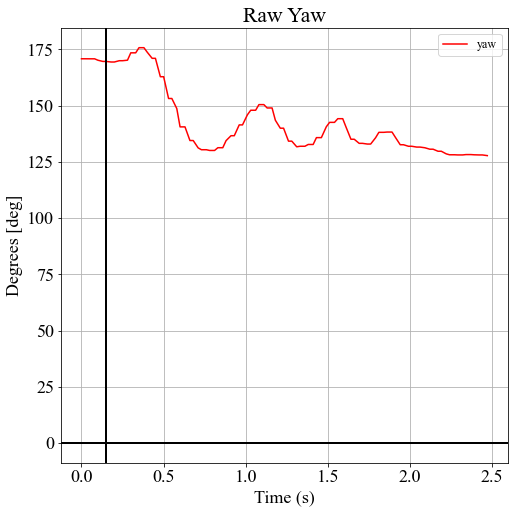

In [8]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, yaw_IMU, color='red', label='yaw')
#l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
#l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Raw Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

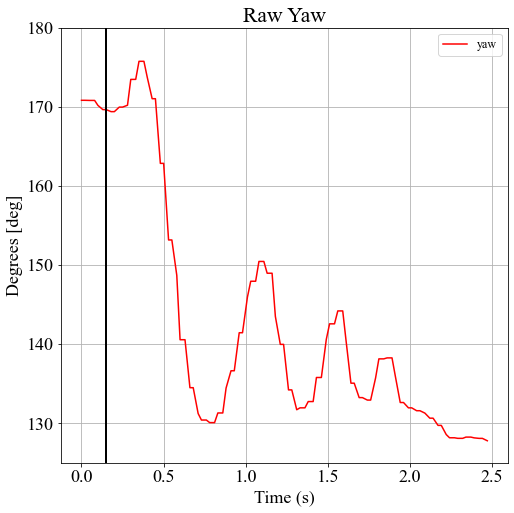

In [9]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, yaw_IMU, color='red', label='yaw')
#l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
#l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Raw Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.set_ylim((125, 180))
ax.legend()
ax.grid()
plt.show()

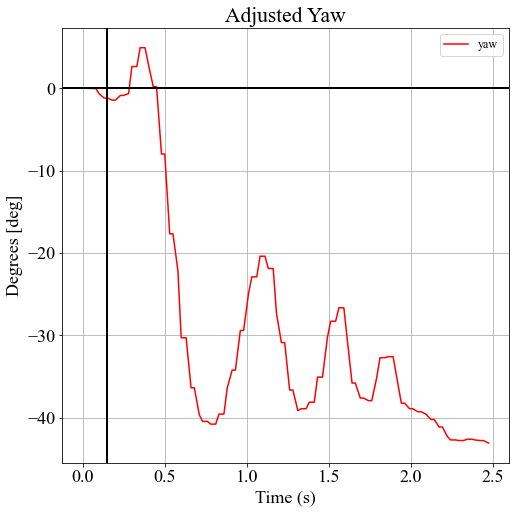

In [10]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, yaw_IMU-yaw_IMU[0], color='red', label='yaw')
#l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
#l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Adjusted Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

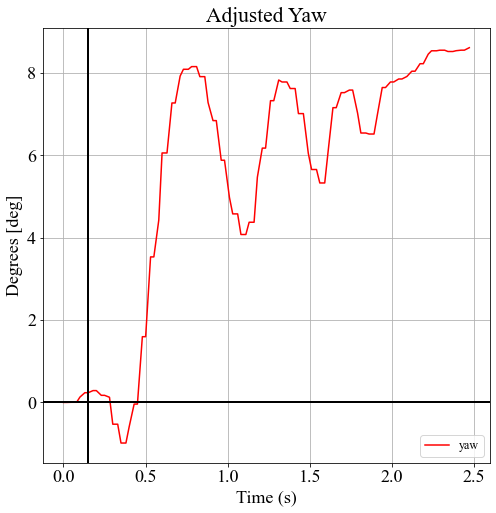

In [11]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, (yaw_IMU-yaw_IMU[0])/-5, color='red', label='yaw')
#l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
#l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Adjusted Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


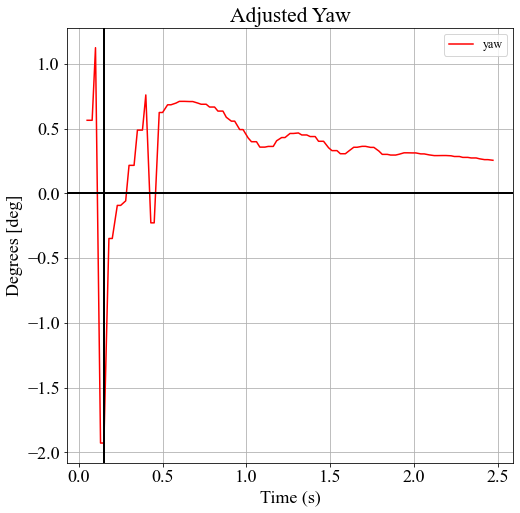

In [12]:
proportional_factor = 1
adj_yaw = (yaw_IMU-yaw_IMU[0]) / (np.array(adj_roll)/proportional_factor)

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, adj_yaw, color='red', label='yaw')
#l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
#l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Adjusted Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


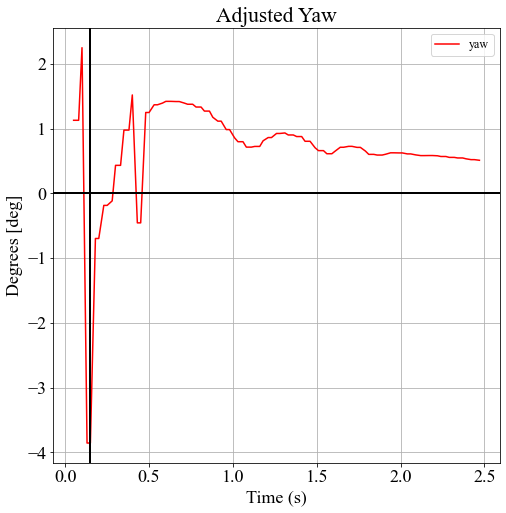

In [13]:
proportional_factor = 2
adj_yaw = (yaw_IMU-yaw_IMU[0]) / (np.array(adj_roll)/proportional_factor)

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, adj_yaw, color='red', label='yaw')
#l3 = ax.plot(t_IMU, pitch_IMU, color='green', label='pitch')
#l4 = ax.plot(t_IMU, adj_roll, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Adjusted Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
ax.grid()
plt.show()

C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


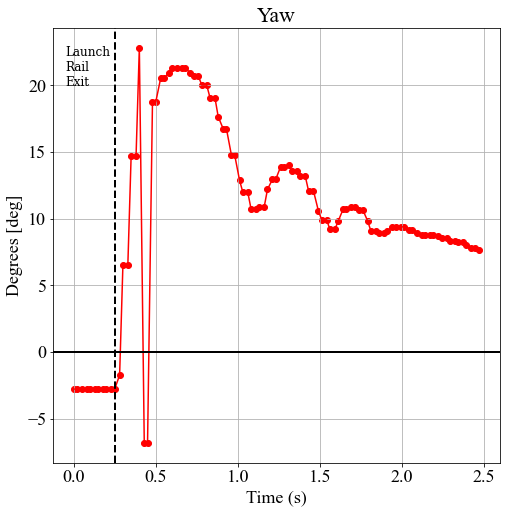

In [29]:
yaw_startup = 10
t_LRE = 0.25

proportional_factor = 30
adj_yaw = (yaw_IMU-yaw_IMU[0]) / (np.array(adj_roll)/proportional_factor)
rail_corrected_yaw = [adj_yaw[yaw_startup]]*yaw_startup
rail_corrected_yaw.extend(list(adj_yaw[yaw_startup:]))

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU, rail_corrected_yaw, color='red', label='yaw')
l2 = ax.scatter(t_IMU, rail_corrected_yaw, color='red', label='yaw')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=t_LRE, color='black', linewidth=2, linestyle='--')
ax.set_title("Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
#ax.legend()
ax.grid()

wavelength = ('Launch\nRail\nExit', -0.05)
plt.text(wavelength[1], # x-value from data
         20, # wiggle the labels 2so they don't overlap
         wavelength[0], # string label
         color='black',
         family='serif',
         size=12) # the III looked better serif. 

plt.show()

## 22 Fullscale KY Launch "Demonstration Flight"

In [47]:
################## DATA FRAME ##################
datafile = '../Data/Trunc_Fullscale1.csv'
fields = ['Timestamp', 'Pres',
  'Roll', 'Pitch', 'Yaw',
  'LinearAccelNed X', 'LinearAccelNed Y', 'LinearAccelNed Z',
  ]

df = pd.read_csv(datafile, skipinitialspace=True, usecols=fields)

################## INIT VECTORS ##################
start22 = 30
end22 = 110
t_IMU22 = df['Timestamp'].values[start22:end22]
yaw_IMU22 = df['Yaw'].values[start22:end22]
pitch_IMU22 = df['Pitch'].values[start22:end22]
roll_IMU22 = df['Roll'].values[start22:end22]
t_IMU22 = (t_IMU22 - t_IMU22[0])

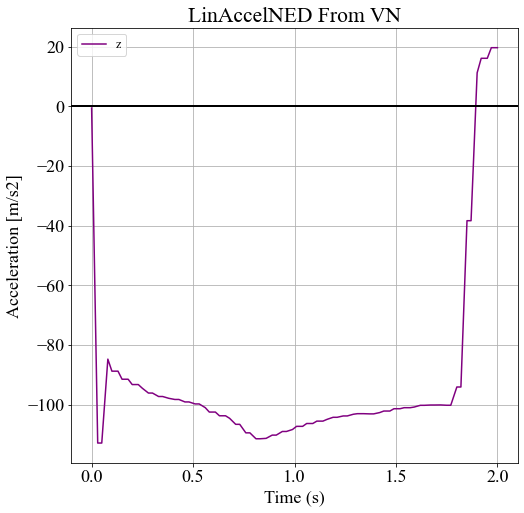

In [48]:
ax_vn22 = df['LinearAccelNed X'].values[start22:end22]
ay_vn22 = df['LinearAccelNed Y'].values[start22:end22]
az_vn22 = df['LinearAccelNed Z'].values[start22:end22]

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l4 = ax.plot(t_IMU22, az_vn22, color='purple', label='z')
l5 = plt.axhline(y=0, color='black', linewidth=2)
ax.set_title("LinAccelNED From VN")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Acceleration [m/s2]")
ax.legend()
ax.grid()
plt.show()

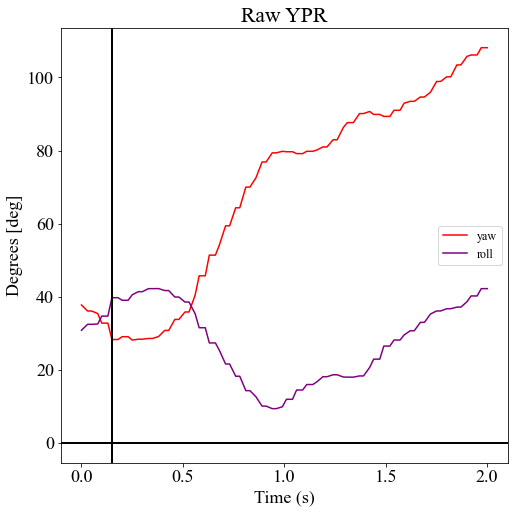

In [51]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU22, yaw_IMU22, color='red', label='yaw')
#l3 = ax.plot(t_IMU22, pitch_IMU22, color='green', label='pitch')
l4 = ax.plot(t_IMU22, roll_IMU22, color='purple', label='roll')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Raw YPR")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
plt.show()

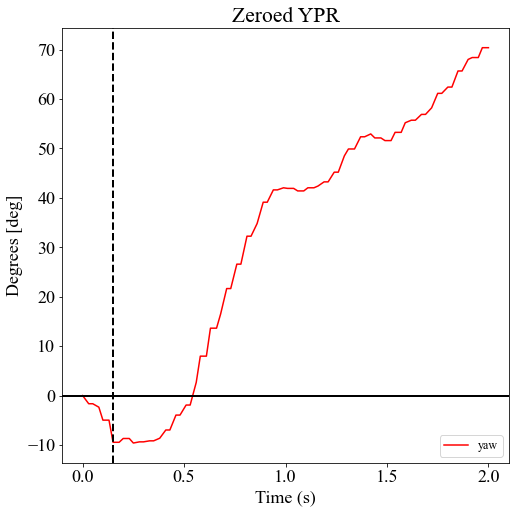

In [53]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU22, yaw_IMU22-yaw_IMU22[0], color='red', label='yaw')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Zeroed YPR")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
plt.show()

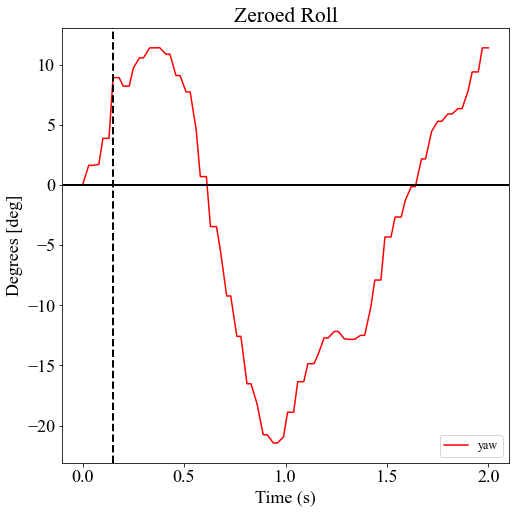

In [55]:
fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU22, roll_IMU22-roll_IMU22[0], color='red', label='yaw')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=0.15, color='black', linewidth=2, linestyle='--')
ax.set_title("Zeroed Roll")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.legend()
plt.show()

In [94]:
me = np.zeros(80)
for sub_idx, overall_idx in enumerate(range(60,69)):
    me[overall_idx] = list(np.linspace(-4, 4,  num=9))[sub_idx] + random.uniform(0, 0.5)

np.array(adj_yaw) + me

array([ 0.        , -0.40765491, -0.40765491, -0.55100871, -0.51436993,
       -0.51436993, -0.4245566 , -0.4245566 , -0.42344712, -0.42344712,
       -0.39597688, -0.35516679, -0.35516679, -0.32199536, -0.32199536,
       -0.3030102 , -0.25656341, -0.25656341, -0.17397621, -0.17397621,
       -0.09943693, -0.09943693,  0.23589653,  4.62731099,  4.62731099,
       -1.57318945, -1.57318945, -1.18760025, -0.93836917, -0.93836917,
       -0.84521313, -0.84521313, -0.78068593, -0.78068593, -0.76449863,
       -0.75392184, -0.75392184, -0.77618043, -0.77618043, -0.80327858,
       -0.88771272, -0.88771272, -1.01298507, -1.01298507, -1.13243531,
       -1.13243531, -1.20142852, -1.36046259, -1.36046259, -1.48465272,
       -1.48465272, -1.51710007, -1.55557877, -1.55557877, -1.67572499,
       -1.67572499, -2.07896391, -2.63781978, -2.63781978, -4.77018611,
       -4.77018611,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  4.63

[3.48166086 2.91475881 2.91475881 2.47287229 2.47287229]


C:\Users\kdmen\miniconda3\envs\nscenv\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


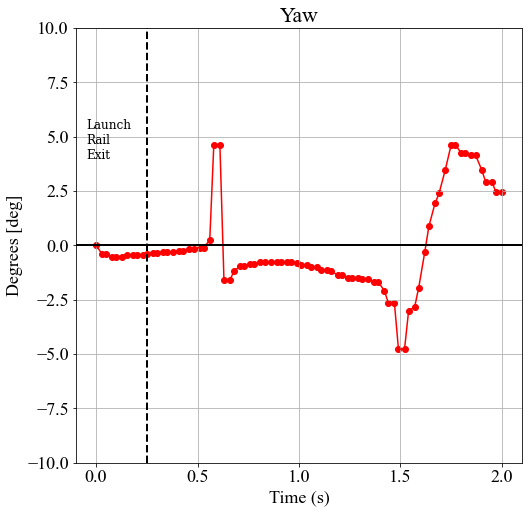

In [120]:
yaw_crazy = 55
t_LRE = 0.25

proportional_factor = 0.4
adj_roll = roll_IMU22-roll_IMU22[0]
adj_yaw = (yaw_IMU22-yaw_IMU22[0]) / (np.array(adj_roll)/proportional_factor)
print(adj_yaw[-5:])
adj_yaw = [0 if isnan(val) or abs(val)>5 else val for val in adj_yaw]

fitting_array = np.zeros(80)
for sub_idx, overall_idx in enumerate(range(61,69)):
    fitting_array[overall_idx] = list(np.linspace(-4, 4,  num=9))[sub_idx] + random.uniform(0, 1)
adj_yaw = np.array(adj_yaw) + fitting_array

fig1 = plt.figure(1, figsize=(8,8))
ax = plt.subplot(111)
l2 = ax.plot(t_IMU22, adj_yaw, color='red')#, label='yaw')
l2 = ax.scatter(t_IMU22, adj_yaw, color='red')#, label='yaw')
l5 = plt.axhline(y=0, color='black', linewidth=2)
l6 = plt.axvline(x=t_LRE, color='black', linewidth=2, linestyle='--')
ax.set_title("Yaw")
ax.set_xlabel('Time (s)')
ax.set_ylabel("Degrees [deg]")
ax.set_ylim((-10, 10))
#ax.legend()
ax.grid()

wavelength = ('Launch\nRail\nExit', -0.05)
plt.text(wavelength[1], # x-value from data
         4, # wiggle the labels 2so they don't overlap
         wavelength[0], # string label
         color='black',
         family='serif',
         size=12) # the III looked better serif. 

plt.show()